In [1]:
import multiprocessing
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from vif_for_contrasts import est_contrast_vifs

%load_ext autoreload
%autoreload 2

from survey_medley_code.config_loader import load_config
from survey_medley_code.outlier_detection_optimized import (
    generate_all_data_summaries_parallel,
)
from survey_medley_code.within_subject_modeling.io_utils import (
    load_tsv_data,
)
from survey_medley_code.within_subject_modeling.timeseries_utils import (
    get_files,
    make_contrasts_question_estimates,
)

# QA tasks
1. Check the cVIFs for all design matrices
2. Assess data for outliers

### The following subjects were skipped due to too many high motion volumes
* s471 (32%)
* s644 (30%)

### Overall summary of what we found
Note: output files including the lists of subjects who should be used in further analyses can be found in: 
```
/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/
    within_subject_question_estimates/within_subject_results/outlier_assessment
```

Generally there is a good agreement between contrasts that were identified as having high VIFs and contrast maps that were determined to be outliers.  The VIF should be viewed as a warning and the final omission decision should be based upon whether the estimates appear to be outliers.

The outlier assessment takes data in each voxel, estimates the mean/sd across subjects and flags a subject if they are 3SD from the mean in that voxel.  The tool produces a pdf that shows a slice of the contrast estimate for each subejct, the subject's outlier percentage (what percent of voxels were outliers) as well as histograms of the within-subject outlier percentages for each contrast and across all contrasts.  Based on the histograms, a threshold of 8% was chosen as this seems to consistently capture the tails fo these histograms well and this is a threshold we have used for other contrasts in this data set.

## 1. VIF summary
Most subjects have elevated VIFs for at least one contrast, which was expected.  Although the VIFs are higher for the questionnaire averages, they will have higher SNR (presumably) and can tolerate a greater increase in varaince than the individual question estimates.

Subjects with many elevated VIFs should be carefully inspected in the outlier analysis.

In [2]:
cfg = load_config()
sub_list_file = (
    cfg.data_root
    / 'analysis_code/survey_medley_code/analyses/assess_subject_bold_dropout/preanalysis_good_subject_list.txt'
)
subids = sub_list_file.read_text().splitlines()
data_dir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results'
)

In [3]:
def get_desmat_contrasts(subid):
    subid_no_s = str.replace(subid, 's', '')
    desmat_path = data_dir / f'{subid_no_s}/design_matrix.csv'
    desmat = pd.read_csv(desmat_path)
    files = get_files(cfg, subid)
    events = load_tsv_data(files['behav'])
    contrast_dict = make_contrasts_question_estimates(events)
    return desmat, contrast_dict


In [4]:
vifs_all = []
failed_subs = []

for subid in subids:
    try:
        desmat, contrast_dict = get_desmat_contrasts(subid)
        vifs = est_contrast_vifs(desmat, contrast_dict)
        vifs['subid'] = subid
        vifs_all.append(vifs)
    except Exception as e:
        print(f'Subject {subid} failed: {e}')
        failed_subs.append(subid)

vif_df = pd.DataFrame(vifs_all)

print(f'Successfully processed {len(vifs_all)} subjects.')
if failed_subs:
    print(f'Failed subjects: {failed_subs}')

Subject s471 failed: [Errno 2] No such file or directory: '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/471/design_matrix.csv'
Subject s644 failed: [Errno 2] No such file or directory: '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/644/design_matrix.csv'
Successfully processed 97 subjects.
Failed subjects: ['s471', 's644']


In [5]:
err_cols = [c for c in vif_df.columns if c.startswith('err_')]

# 1️⃣ Create response_error column: 1 if any err column is non-missing
vif_df['response_error'] = vif_df[err_cols].notna().any(axis=1).astype(int)

# 2️⃣ Copy values from err columns into corresponding Q## columns
for err_col in err_cols:
    main_col = err_col.replace('err_', '')
    # Only update where err_col is non-missing
    vif_df.loc[vif_df[err_col].notna(), main_col] = vif_df.loc[
        vif_df[err_col].notna(), err_col
    ]


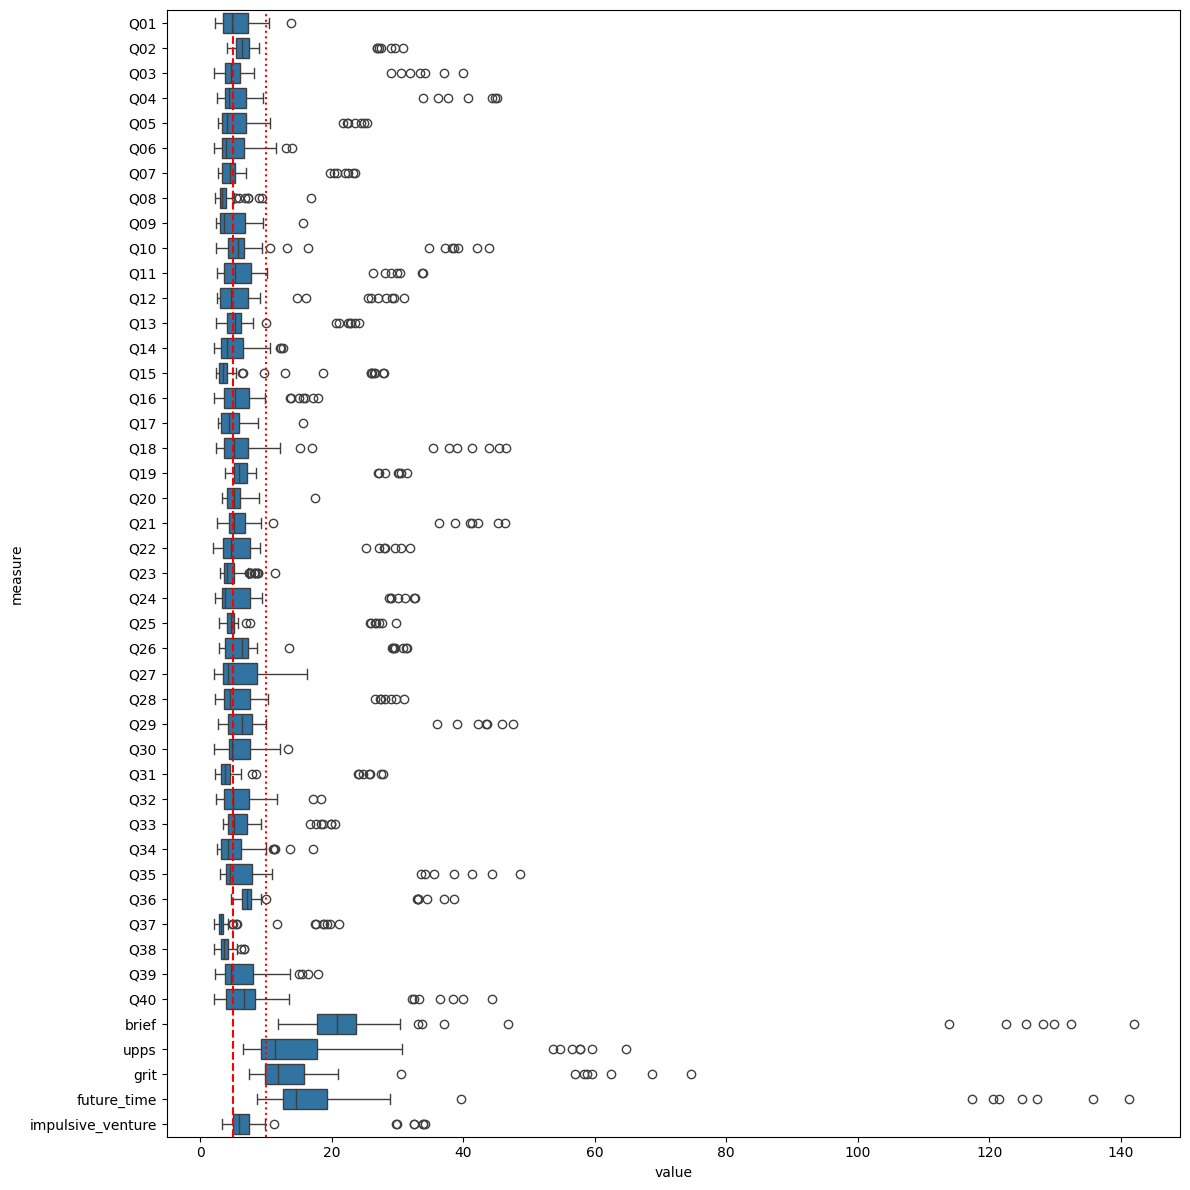

In [6]:
# Columns to plot: all Q## plus the other specified ones
plot_cols = sorted([col for col in vif_df.columns if col.startswith('Q')]) + [
    'brief',
    'upps',
    'grit',
    'future_time',
    'impulsive_venture',
]

# Melt into long format
vif_long = vif_df.melt(
    id_vars=['subid'], value_vars=plot_cols, var_name='measure', value_name='value'
)

# Make violin plot
plt.figure(figsize=(12, 12))
sns.boxplot(y='measure', x='value', data=vif_long)
# plt.xticks(rotation=90)
plt.axvline(x=5, color='red', linestyle='--')
plt.axvline(x=10, color='red', linestyle=':')
plt.tight_layout()
plt.show()

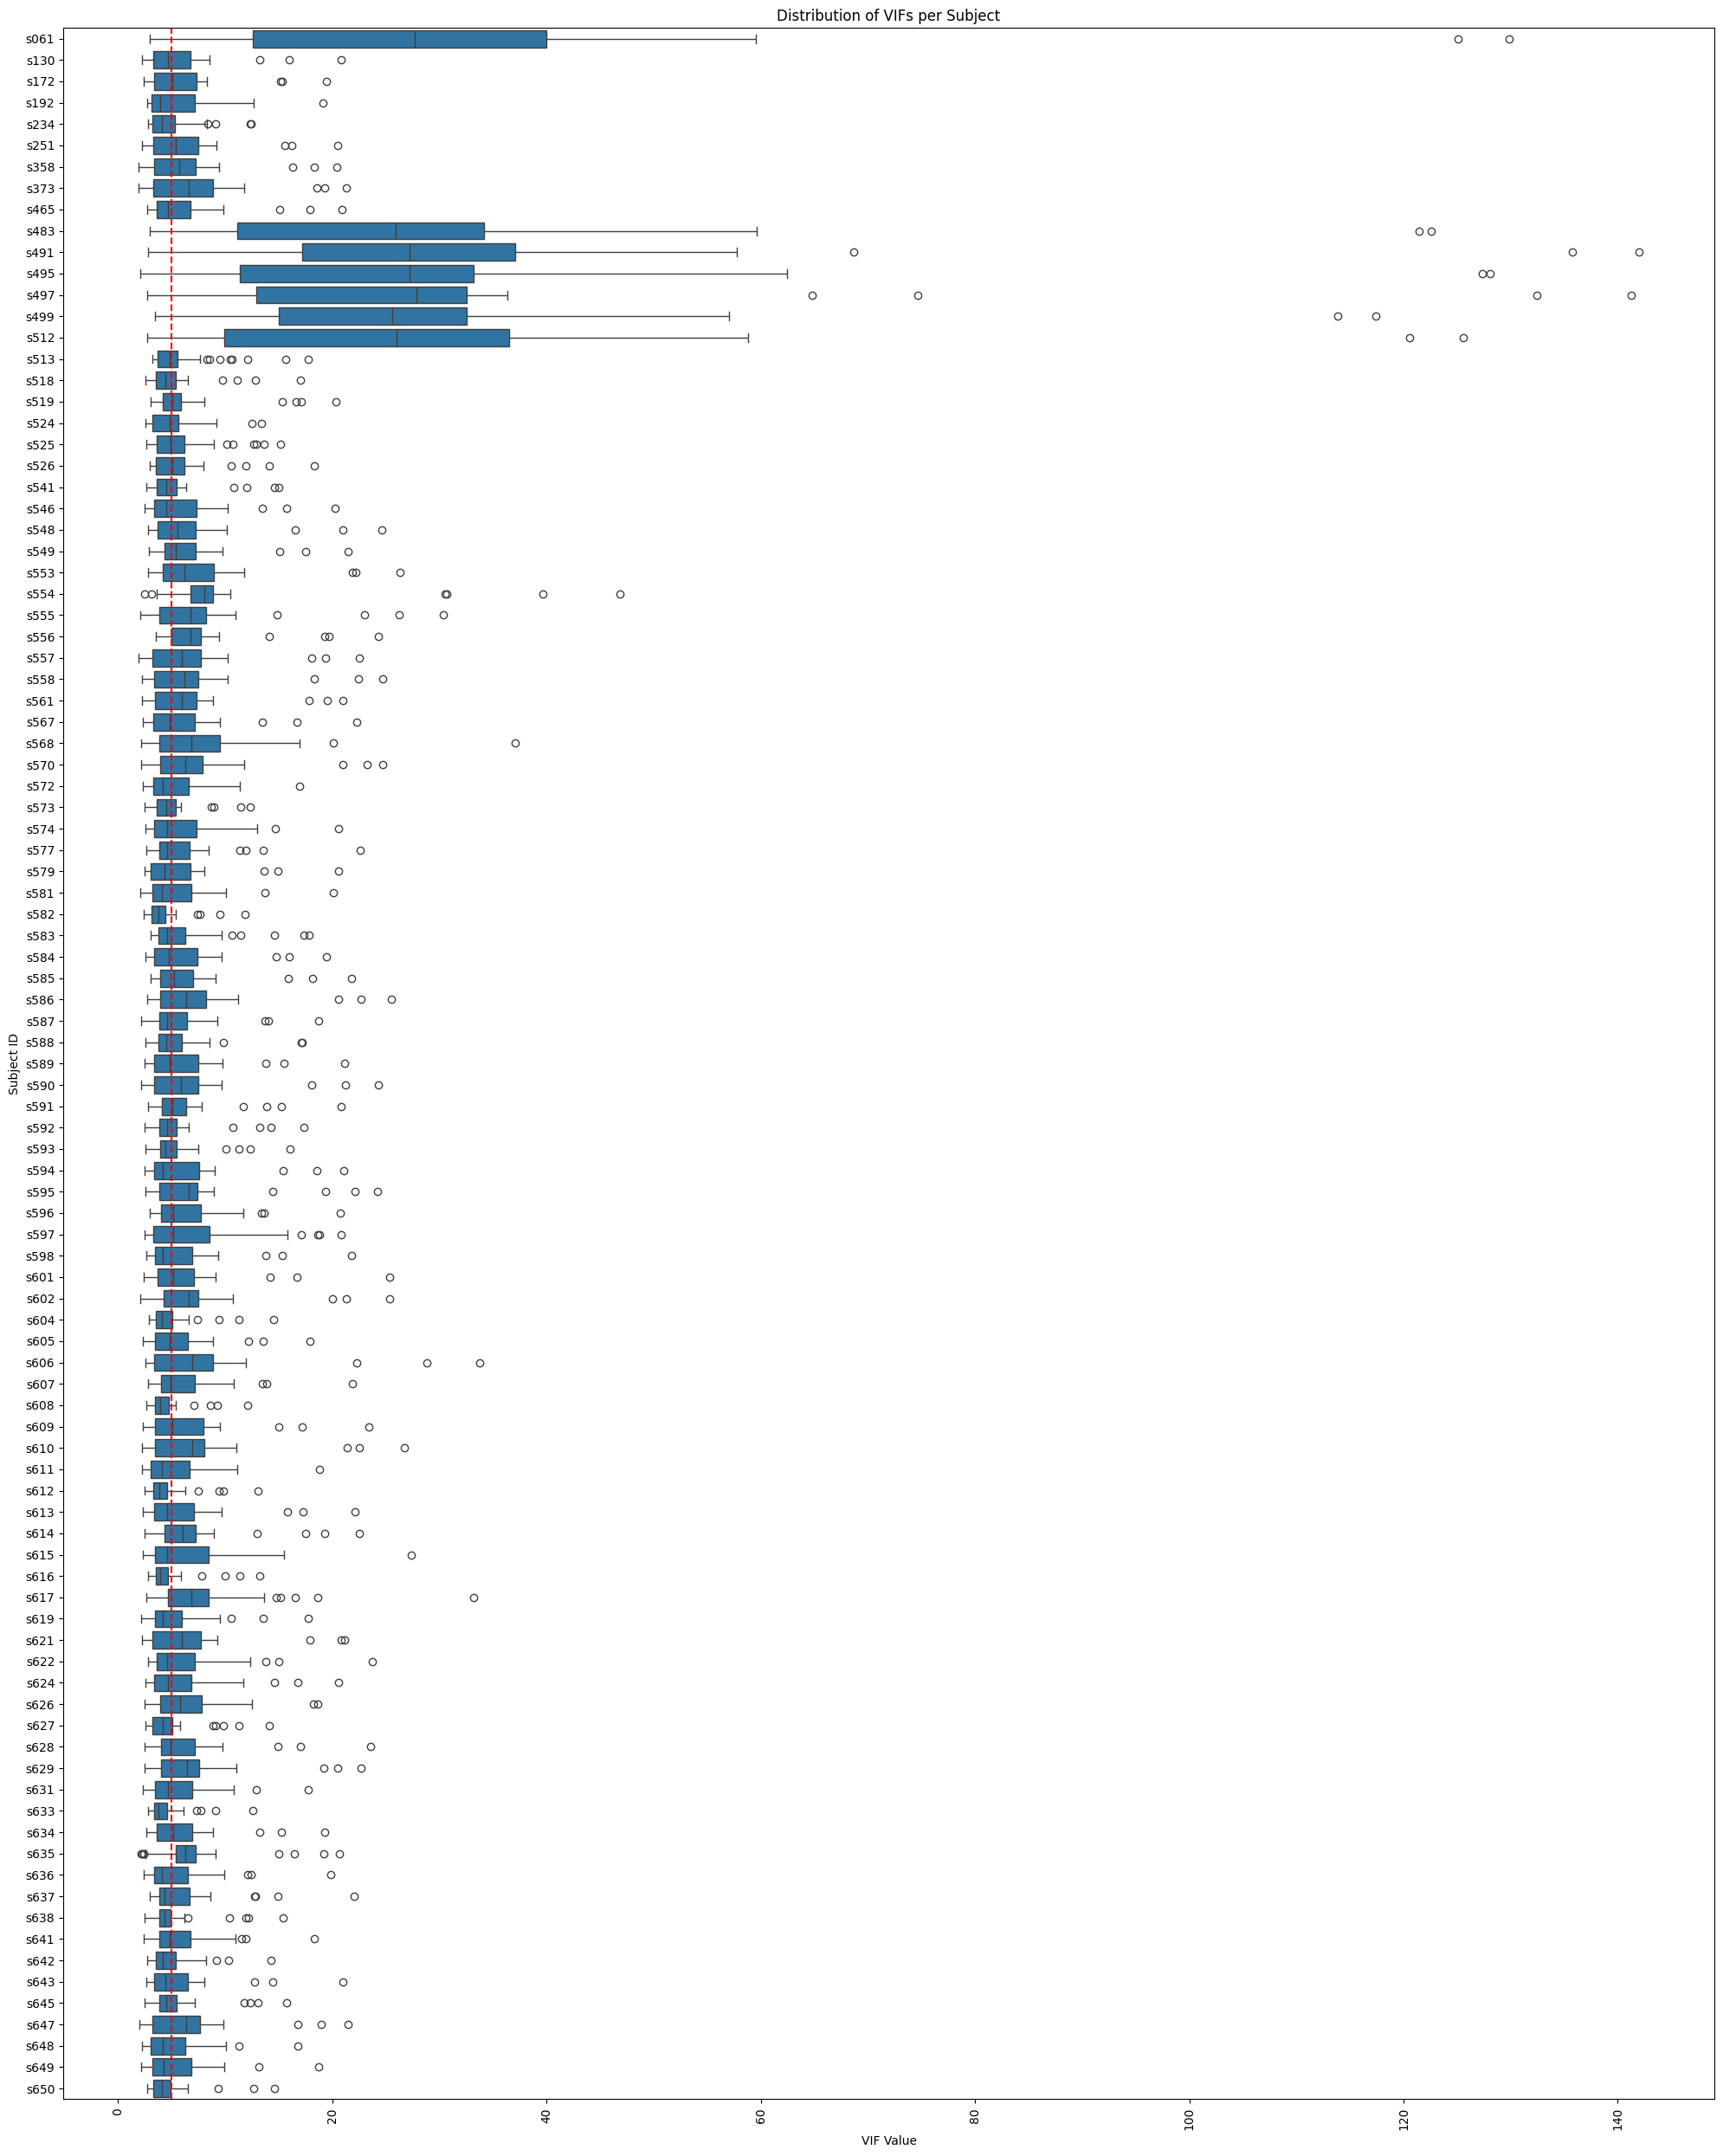

In [7]:
# Columns to include in the plot
value_cols = [col for col in vif_df.columns if col.startswith('Q')] + [
    'brief',
    'upps',
    'grit',
    'future_time',
    'impulsive_venture',
]

# Melt to long format
vif_long = vif_df.melt(
    id_vars='subid', value_vars=value_cols, var_name='measure', value_name='value'
)

# Plot
plt.figure(figsize=(20, 25))
sns.boxplot(y='subid', x='value', data=vif_long)
plt.axvline(x=5, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('Subject ID')
plt.xlabel('VIF Value')
plt.title('Distribution of VIFs per Subject')
plt.tight_layout()
plt.show()

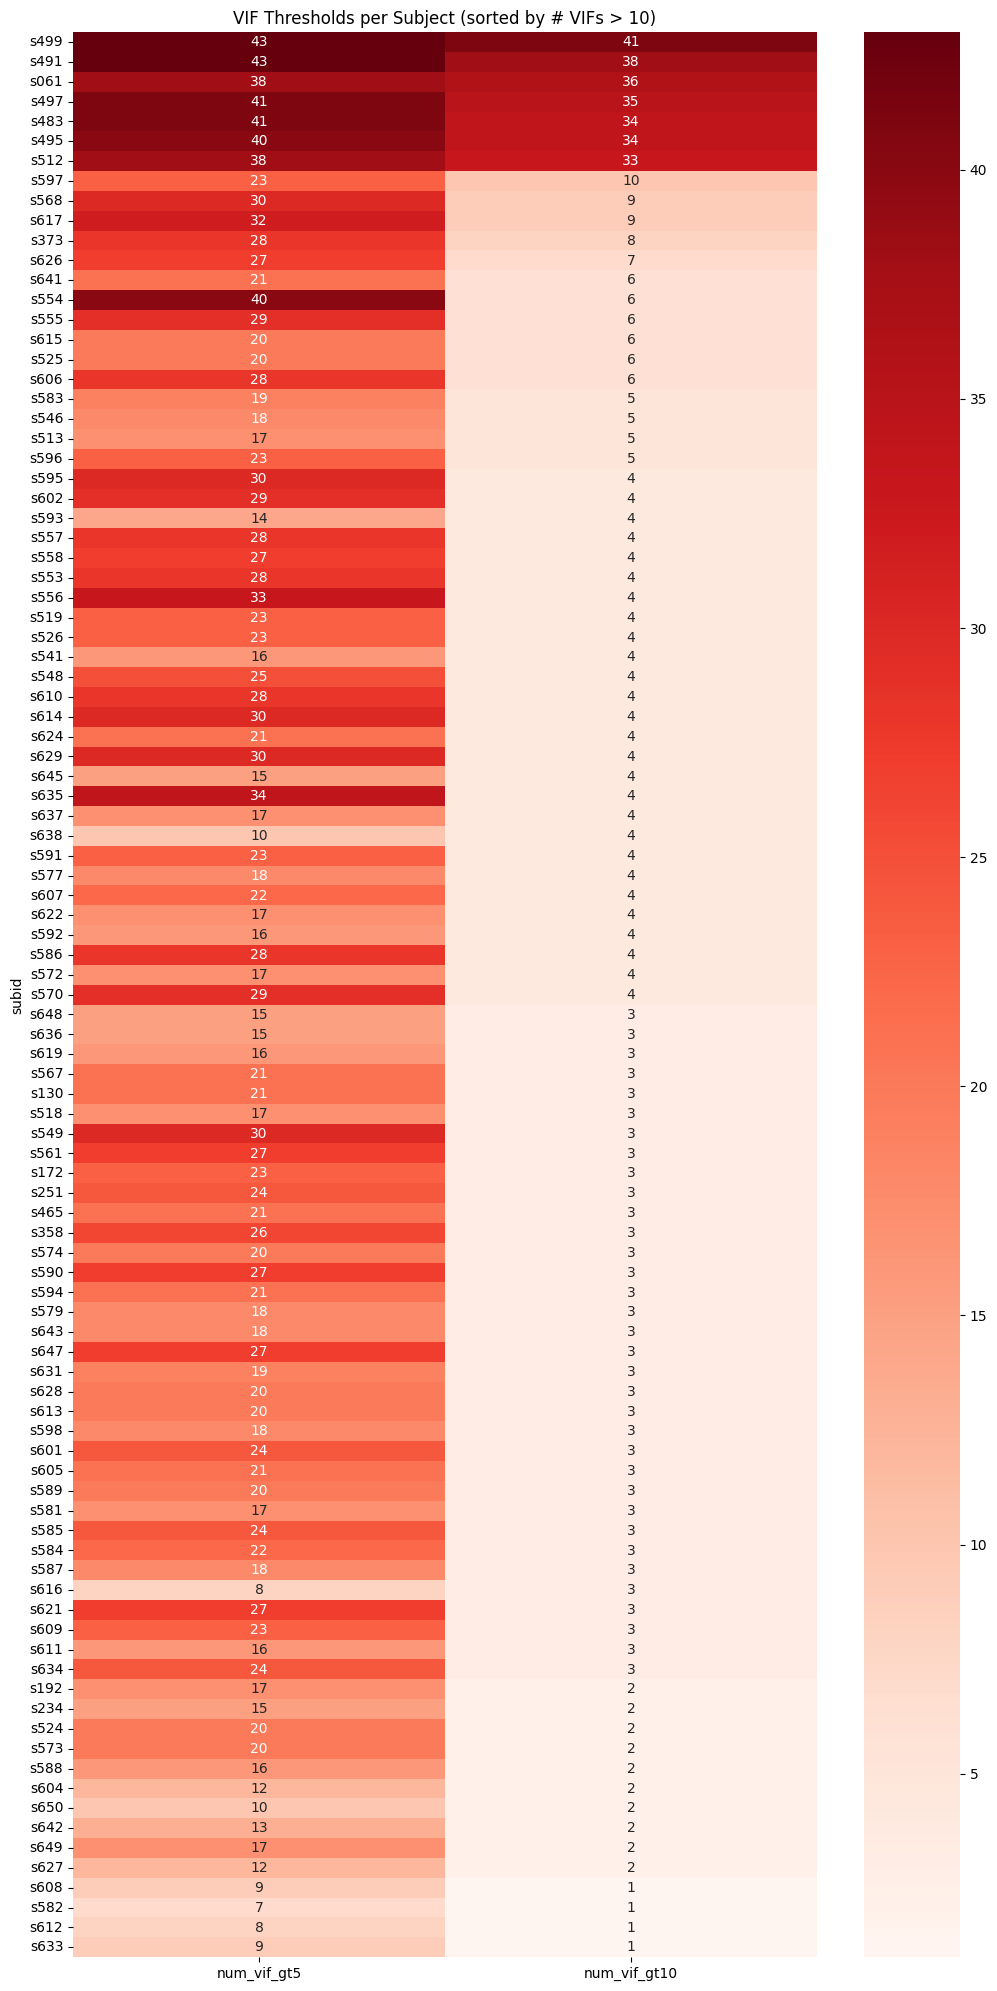

In [8]:
# count how many elevated VIFs for each subject
q_cols = [c for c in vif_df.columns if c.startswith('Q')]
extra_cols = ['brief', 'upps', 'grit', 'future_time', 'impulsive_venture']
cols_to_check = q_cols + extra_cols

# Count >5 and >10 for each row
summary_df = pd.DataFrame(
    {
        'subid': vif_df['subid'],
        'num_vif_gt5': (vif_df[cols_to_check] > 5).sum(axis=1),
        'num_vif_gt10': (vif_df[cols_to_check] > 10).sum(axis=1),
    }
)

# Sort by num_vif_gt10 descending
heatmap_df = summary_df.sort_values('num_vif_gt10', ascending=False).set_index('subid')[
    ['num_vif_gt5', 'num_vif_gt10']
]

plt.figure(figsize=(12, 25))
sns.heatmap(heatmap_df, annot=True, cmap='Reds', cbar=True)
plt.title('VIF Thresholds per Subject (sorted by # VIFs > 10)')
plt.show()

## 2. Outlier assessment

Not surprisingly, many of the subjects who were found to have outlying statistics across the brain (in more than 8% of the voxels) are also the subjects who had high VIFs.  A comparable figure to the VIF figure is made below.

In [9]:
contrast_names = [f'Q{num:02d}' for num in range(1, 41)] + [
    'brief',
    'upps',
    'grit',
    'future_time',
    'impulsive_venture',
]


In [10]:
from survey_medley_code.analysis_provenance import log_provenance

data_root = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results'
)


dict_list = []

for contrast_name in contrast_names:
    print(contrast_name)
    subids_loop = []
    nifti_paths_loop = []
    for subid in subids:
        subid_no_s = str.replace(subid, 's', '')
        contrast_name = contrast_name
        pattern = f'{subid_no_s}/contrast_*{contrast_name}_effect_size_sub_{subid_no_s}.nii.gz'
        sub_nifti_paths = list(data_root.glob(pattern))
        if len(sub_nifti_paths) == 1:
            subids_loop.append(subid)
            nifti_paths_loop.append(sub_nifti_paths[0])
        else:
            print(f'sub {subid} had {len(sub_nifti_paths)} files for {contrast_name}')
    data_dict_loop = {
        'main_title': contrast_name,
        'nifti_paths': nifti_paths_loop,
        'image_labels': subids_loop,
        'data_type_label': 'contrast estimate',
    }
    dict_list.append(data_dict_loop)


Q01
sub s471 had 0 files for Q01
sub s644 had 0 files for Q01
Q02
sub s471 had 0 files for Q02
sub s644 had 0 files for Q02
Q03
sub s471 had 0 files for Q03
sub s644 had 0 files for Q03
Q04
sub s471 had 0 files for Q04
sub s644 had 0 files for Q04
Q05
sub s471 had 0 files for Q05
sub s644 had 0 files for Q05
Q06
sub s471 had 0 files for Q06
sub s644 had 0 files for Q06
Q07
sub s471 had 0 files for Q07
sub s644 had 0 files for Q07
Q08
sub s471 had 0 files for Q08
sub s644 had 0 files for Q08
Q09
sub s471 had 0 files for Q09
sub s644 had 0 files for Q09
Q10
sub s471 had 0 files for Q10
sub s644 had 0 files for Q10
Q11
sub s471 had 0 files for Q11
sub s644 had 0 files for Q11
Q12
sub s471 had 0 files for Q12
sub s644 had 0 files for Q12
Q13
sub s471 had 0 files for Q13
sub s644 had 0 files for Q13
Q14
sub s471 had 0 files for Q14
sub s644 had 0 files for Q14
Q15
sub s471 had 0 files for Q15
sub s644 had 0 files for Q15
Q16
sub s471 had 0 files for Q16
sub s644 had 0 files for Q16
Q17
sub 

In [11]:
n_cpus = multiprocessing.cpu_count()
print(f'Detected {n_cpus} CPUs')

n_workers = min(n_cpus, 20)

Detected 24 CPUs


In [12]:
outlier_root = data_root / 'outlier_assessment'
shutil.rmtree(outlier_root, ignore_errors=True)
outlier_root.mkdir(parents=True, exist_ok=True)

this_notebook = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/analyses/within_subject_question_estimates/qa_outputs.ipynb'

log_provenance(outlier_root, settings={'notebook_file': this_notebook})

generate_all_data_summaries_parallel(
    dict_list, n_std=3, output_dir=outlier_root, n_workers=n_workers
)


Finished Q18
Finished Q20
Finished Q11
Finished Q03
Finished Q09
Finished Q14
Finished Q16
Finished Q15
Finished Q12
Finished Q19
Finished Q07
Finished Q08
Finished Q10
Finished Q13
Finished Q06
Finished Q05
Finished Q17
Finished Q04
Finished Q02
Finished Q01
Finished Q21
Finished Q27
Finished Q26
Finished Q23
Finished Q22
Finished Q25
Finished Q31
Finished Q24
Finished Q32
Finished Q34
Finished Q28
Finished Q33
Finished Q30
Finished Q29
Finished Q35
Finished Q37
Finished Q36
Finished Q39
Finished Q38
Finished Q40
Finished future_time
Finished grit
Finished upps
Finished brief
Finished impulsive_venture
PDF saved to /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/outlier_assessment/outlier_analysis.pdf
All done! PDF saved to /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/outlier_assessment/outlier_analysis.pdf


In [13]:
outlier_root

PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/outlier_assessment')

In [14]:
# After viewing the pdf that was generated above, it appears we should stick with the 8% cutoff that we typically use.

outlier_output = pd.read_csv(outlier_root / 'percent_outlier_data.csv')

In [15]:
for contrast, df_group in outlier_output.groupby('contrast_name'):
    # Save "good" subjects (< 8) to a text file
    good_subjects = df_group[df_group['image_outlier_percentage'] < 8]['subject_label']
    txt_path = outlier_root / f'subjects_outlier_percent_lt_8_contrast_{contrast}.txt'
    good_subjects.to_csv(txt_path, index=False, header=False)

### Compare the outlier counts to the earlier VIF threshold violations

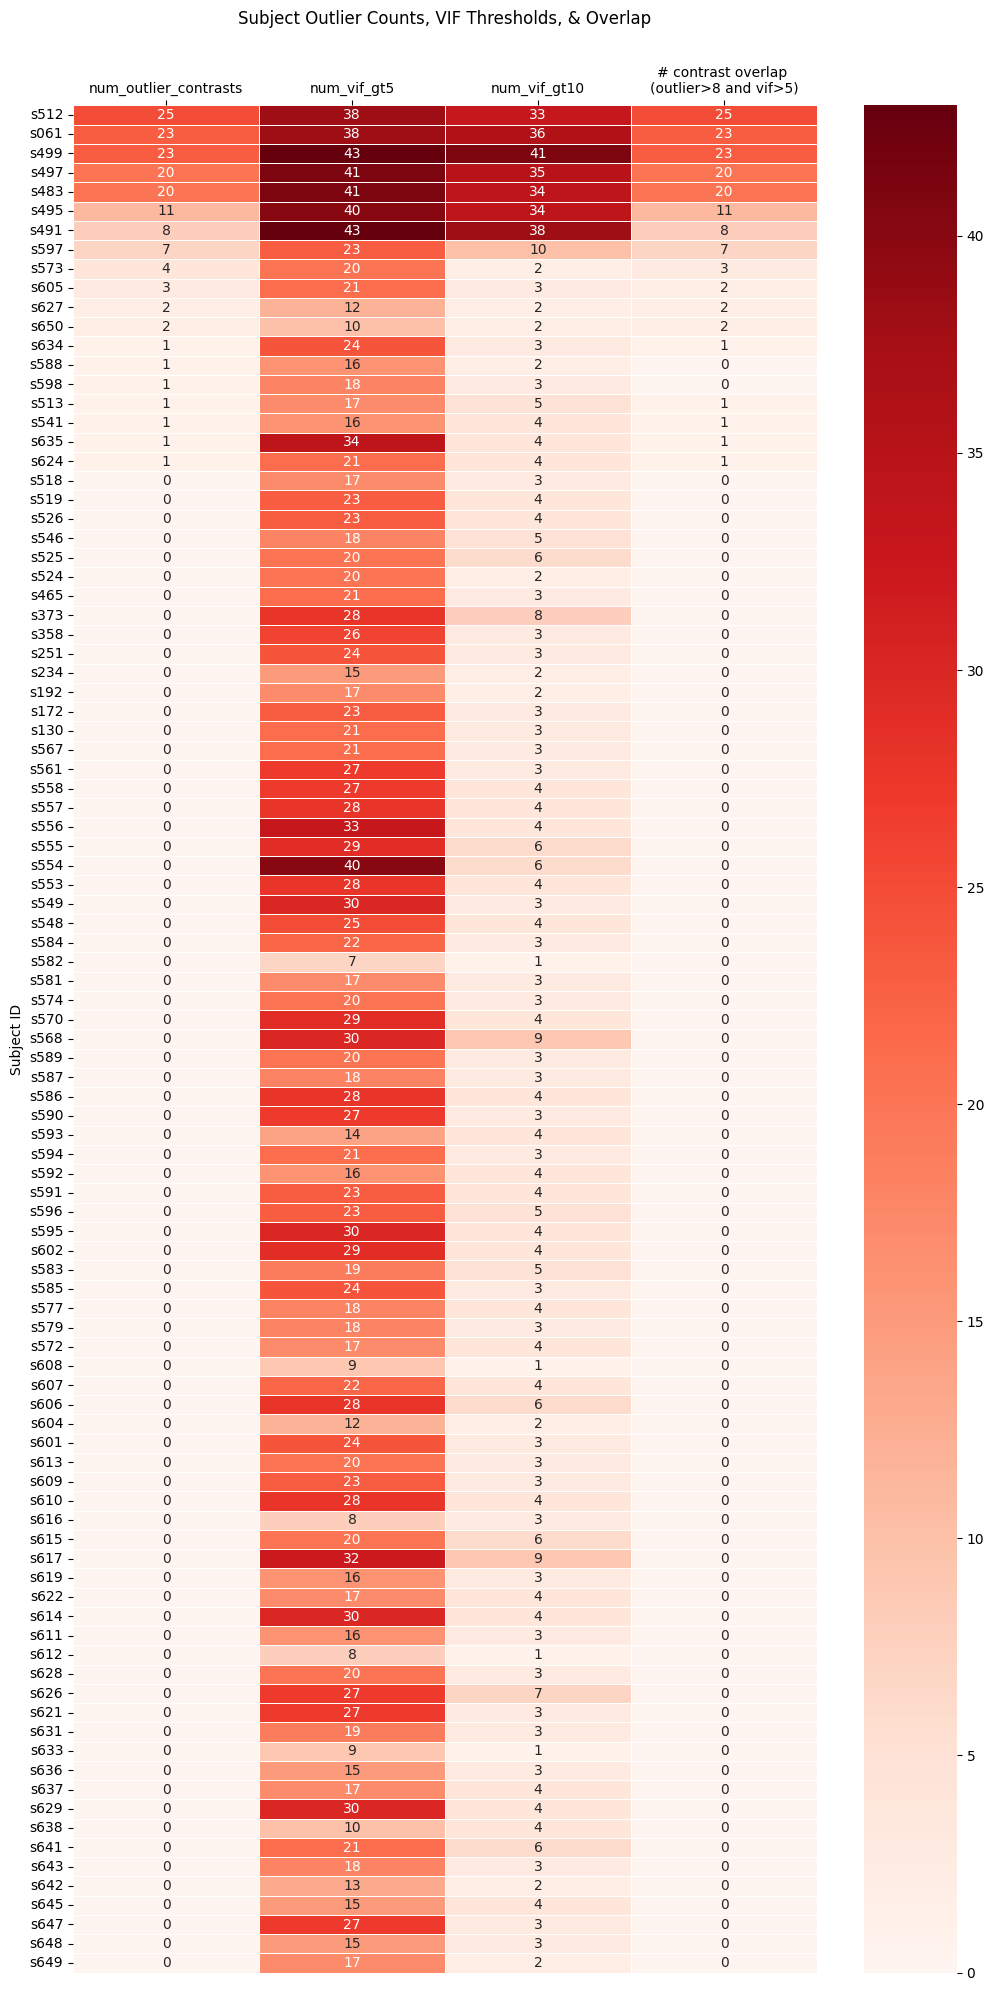

In [16]:
# --- Prepare outlier counts ---
outlier_counts = (
    outlier_output[outlier_output['image_outlier_percentage'] >= 8]
    .groupby('subject_label')
    .size()
    .reset_index(name='num_outlier_contrasts')
)

all_subjects = pd.DataFrame({'subject_label': vif_df['subid'].unique()})
outlier_summary = all_subjects.merge(
    outlier_counts, left_on='subject_label', right_on='subject_label', how='left'
)
outlier_summary['num_outlier_contrasts'] = (
    outlier_summary['num_outlier_contrasts'].fillna(0).astype(int)
)

# --- Prepare VIF summary ---
q_cols = [c for c in vif_df.columns if c.startswith('Q')]
extra_cols = ['brief', 'upps', 'grit', 'future_time', 'impulsive_venture']
cols_to_check = q_cols + extra_cols

vif_summary = pd.DataFrame(
    {
        'subid': vif_df['subid'],
        'num_vif_gt5': (vif_df[cols_to_check] > 5).sum(axis=1),
        'num_vif_gt10': (vif_df[cols_to_check] > 10).sum(axis=1),
    }
)

# ---Combine the two dataframes ---
combined_df = outlier_summary.merge(
    vif_summary, left_on='subject_label', right_on='subid', how='left'
)
combined_df = combined_df[
    ['subject_label', 'num_outlier_contrasts', 'num_vif_gt5', 'num_vif_gt10']
]

# --- Map subjects to contrasts where they are outliers ---
outlier_subject_contrasts = (
    outlier_output[outlier_output['image_outlier_percentage'] >= 8]
    .groupby('subject_label')['contrast_name']
    .apply(set)
    .to_dict()
)

# --- Map subjects to contrasts where VIF > 5 ---
vif_subject_contrasts = {}
for sub in vif_df['subid']:
    # find which columns exceed 5 for this subject
    row = vif_df[vif_df['subid'] == sub]
    high_vif_cols = set(
        row[cols_to_check].columns[row[cols_to_check].gt(5).any()].tolist()
    )
    vif_subject_contrasts[sub] = high_vif_cols


# --- Compute intersection counts ---
def compute_overlap(sub):
    outlier_set = outlier_subject_contrasts.get(sub, set())
    vif_set = vif_subject_contrasts.get(sub, set())
    return len(outlier_set & vif_set)


# --- Add as a new column ---
combined_df['# contrast overlap \n(outlier>8 and vif>5)'] = combined_df[
    'subject_label'
].apply(compute_overlap)

# --- Re-sort and plot heatmap ---
heatmap_df = combined_df.sort_values(
    'num_outlier_contrasts', ascending=False
).set_index('subject_label')

plt.figure(figsize=(12, len(heatmap_df) * 0.25))
ax = sns.heatmap(heatmap_df, annot=True, cmap='Reds', cbar=True, linewidths=0.5)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.title('Subject Outlier Counts, VIF Thresholds, & Overlap', pad=30)
plt.ylabel('Subject ID')
plt.show()


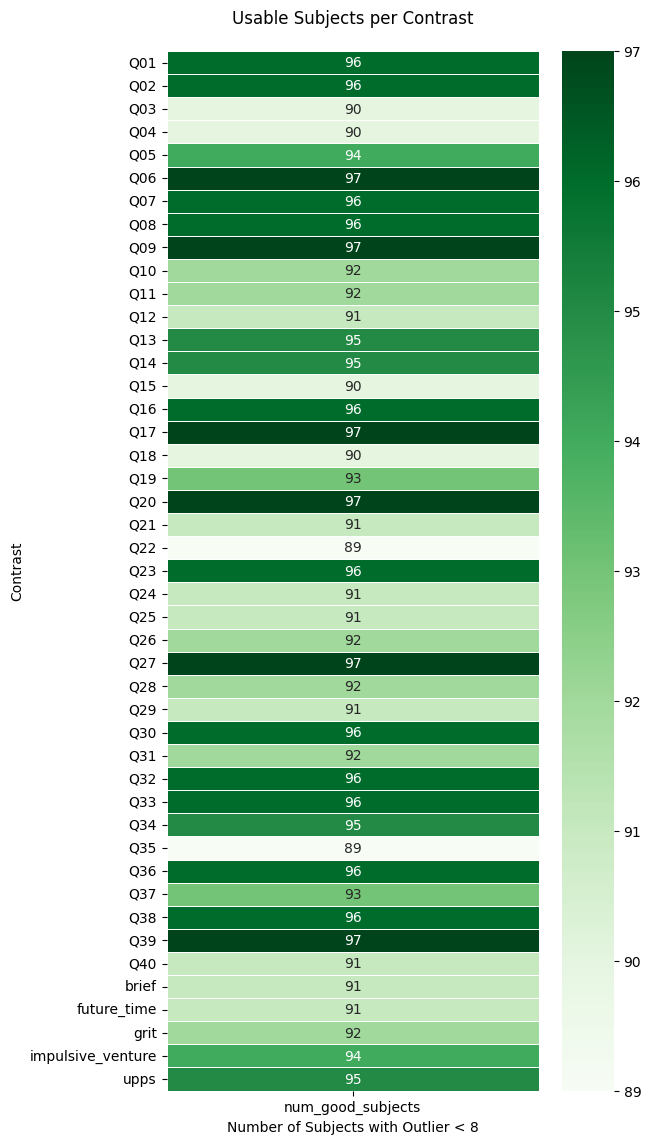

In [17]:
# Compute number of "good" subjects per contrast
usable_subjects = (
    outlier_output[outlier_output['image_outlier_percentage'] < 8]
    .groupby('contrast_name')['subject_label']
    .count()
    .reset_index(name='num_good_subjects')
)

# Pivot for heatmap format: y-axis = contrast, single column
heatmap_df = usable_subjects.set_index('contrast_name')

plt.figure(figsize=(6, len(heatmap_df) * 0.3))
ax = sns.heatmap(
    heatmap_df, annot=True, fmt='d', cmap='Greens', cbar=True, linewidths=0.5
)

ax.set_ylabel('Contrast')
ax.set_xlabel('Number of Subjects with Outlier < 8')
plt.title('Usable Subjects per Contrast', pad=20)
plt.show()